## Utilizing Hierarchical Structure for Audio-Based Music Similarity
#### Christos Plachouras, ISMIR 2021 Late-Break Demo, [Code](https://github.com/chrispla/align-and-compare), [Paper](https://archives.ismir.net/ismir2021/latebreaking/000057.pdf), [Poster](https://s3.eu-west-1.amazonaws.com/production-main-contentbucket52d4b12c-1x4mwd6yn8qjn/1c8eb7df-d463-4bc5-b33e-ac615490788c.pdf), [Video](https://youtu.be/0yJkVQqi67U)


This notebook provides code for demonstrating how the method works for comparing two audio files.

### > Library importing

In [1]:
# for audio processing
import librosa
# for plotting
import librosa.display
import matplotlib.pyplot as plt 
# for matrix processing
import numpy as np
import scipy
# for spectral clustering
import sklearn.cluster

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### > Paths and Parameters
Choose paths for the two audio files, configure parameters for structure analysis

In [3]:
# Audio file paths
path1 = '/content/drive/MyDrive/RWC/rwc pop/10.wav'
path2 = '/content/drive/MyDrive/RWC/rwc pop/11.wav'

In [4]:
# Constant-Q Transform parameters
BINS_PER_OCTAVE = 12 * 3
N_OCTAVES = 7

# Spectral clustering parameters (spectral clustering component translates to number of segment types)
kmin = 2  # needs to be >=2
kmax = 7

### > Hierarchical structure analysis

Code modified from [Brian McFee - Laplacian Segmentation (MIT License)](https://github.com/bmcfee/lsd_viz)

Brian McFee, Dan Ellis. "Analyzing Song Structure with Spectral Clustering". ISMIR 2014.


#### >> Compute Laplacian
First, we compute the Constant-Q Transform of the audio file and beat-synchronize it. Then, we compute an affinity matrix encoding the self-similarity of each frame of the CQT, and combine it with a sequence matrix encoding the local consistency of MFCCs. Finally, we compute the Laplacian to shift it to its matrix representation.

In [5]:
def compute_laplacian(path, BINS_PER_OCTAVE, N_OCTAVES):
    """
    Compute the Laplacian matrix from an audio file using
    its Constant-Q Transform.

    Input
    -----
    path: filepath (str)

    Output
    -----
    y: audio samples (np.array) - returned for plotting
    C: Constant-Q Transform (np.array) - returned for plotting
    beat_times: beats in seconds - returned for format_segments()
    L: Laplacian matrix (np.array)
    """

    # load audio
    y, sr = librosa.load(path, sr=22050, mono=True)

    # Compute Constant-Q Transform in dB
    C = librosa.amplitude_to_db(np.abs(librosa.cqt(y=y,
                                                   sr=sr,
                                                   bins_per_octave=BINS_PER_OCTAVE,
                                                   n_bins=N_OCTAVES * BINS_PER_OCTAVE)),
                                                   ref=np.max)

    # beat tracking
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
    # get beat times in seconds
    beat_times = librosa.frames_to_time(librosa.util.fix_frames(beats, x_min=0, x_max=C.shape[1]), sr=sr)

    # beat synchronize the CQT
    Csync = librosa.util.sync(C, beats, aggregate=np.median)

    # stack 4 consecutive frames
    Cstack = librosa.feature.stack_memory(Csync, 4)

    # compute weighted recurrence matrix
    R = librosa.segment.recurrence_matrix(Cstack, width=3, mode='affinity', sym=True)

    # enhance diagonals with a median filter
    df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
    Rf = df(R, size=(1, 7))
    Rf = librosa.segment.path_enhance(Rf, 15)

    # compute MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    # beat synchronize them
    Msync = librosa.util.sync(mfcc, beats)

    # build the MFCC sequence matrix
    path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
    sigma = np.median(path_distance)
    path_sim = np.exp(-path_distance / sigma)
    R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)

    # get the balanced combination of the MFCC sequence matric and the CQT
    deg_path = np.sum(R_path, axis=1)
    deg_rec = np.sum(Rf, axis=1)
    mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)
    A = mu * Rf + (1 - mu) * R_path

    # compute the normalized Laplacian
    L = scipy.sparse.csgraph.laplacian(A, normed=True)

    return y, C, beat_times, L

#### >> Segment and cluster

We eigendecompose the Laplacian and make sets of its first integer k in [kmin, kmax) eigenvectors. We then perform spectral clustering on each set using the respective number k of clusters. We also compute the Euclidean self-distance of the eigenvectors across time for each set to create "approximations" of the Laplacian for visualization purposes.

In [6]:
def segment(L, kmin, kmax):
    """
    Decompose Laplacian and make sets of its first integer k in [kmin, kmax] eigenvectors.
    For each set, compute its Euclidean self distance over time, and do spectral clustering.

    Input
    -----
    L: Laplacian matrix (np.array)
    kmin: first eigenvector index
    kmax: last eigenvector index

    Output
    -----
    distances: self distance matrix of each set of first eigenvectors (np.array, shape=(kmax-kmin, beats, beats))
    segments: estimated structural segments for each set of first eigenvectors (np.array, shape=(kmax-kmin, beats))
    """

    # eigendecomposition
    evals, evecs = scipy.linalg.eigh(L)

    # eigenvector filtering
    evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))

    # normalization
    Cnorm = np.cumsum(evecs**2, axis=1)**0.5

    # initialize sets
    distances = []
    segments = []

    for k in range(kmin, kmax):
        # create set using first k normalized eigenvectors
        Xs = evecs[:, :k] / Cnorm[:, k-1:k]

        # get self distance over time of the set
        distances.append(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Xs, metric='euclidean')))

        # cluster each set k using k clusters to get k segment types
        KM = sklearn.cluster.KMeans(n_clusters=k, n_init=50, max_iter=500)
        segments.append(KM.fit_predict(Xs))

    return np.asarray(distances), np.asarray(segments)

#### >> Run and plot

In [7]:
# Compute Laplacian using the Constant-Q Transform
y1, C1, beat_times1, L1 = compute_laplacian(path1, BINS_PER_OCTAVE, N_OCTAVES)
y2, C2, beat_times2, L2 = compute_laplacian(path2, BINS_PER_OCTAVE, N_OCTAVES)

# Compute Laplacian approximations and hierarchical structural analysis 
d1, s1 = segment(L1, kmin, kmax)
d2, s2 = segment(L2, kmin, kmax)

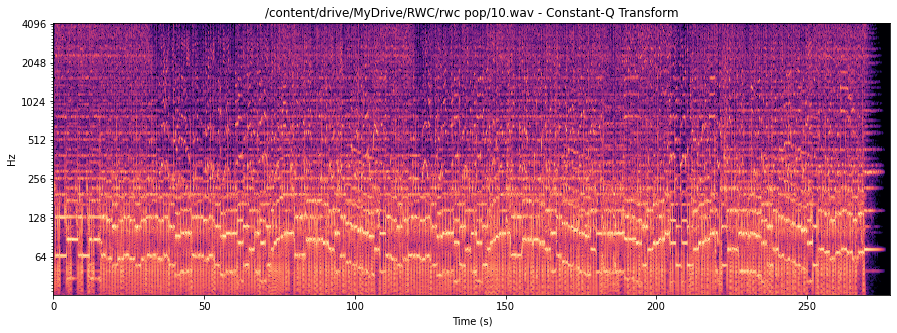

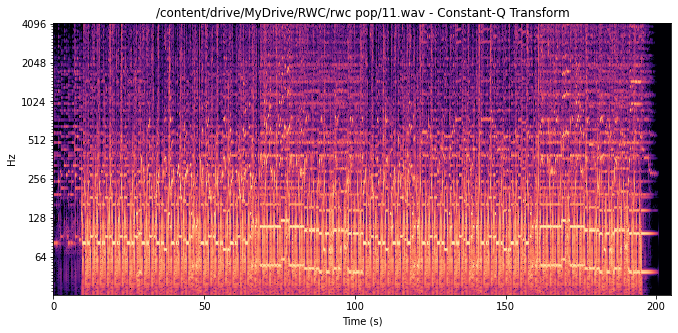

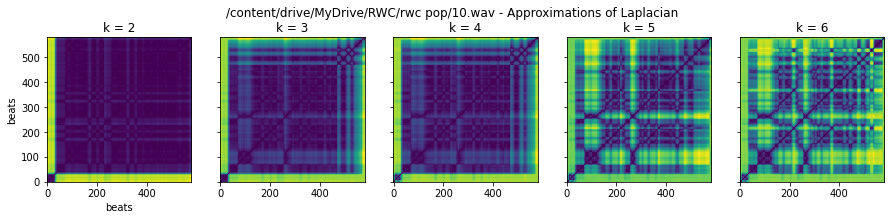

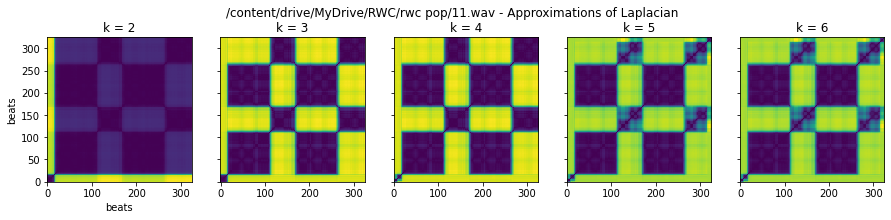

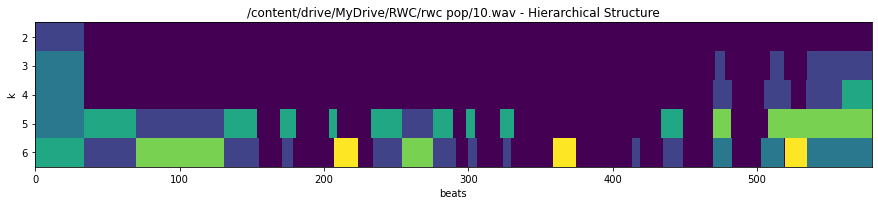

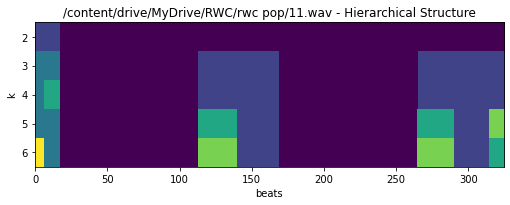

In [8]:
# get relative scale of beat vectors for ploting
cqt_scale1 = min(1, C1.shape[1]/C2.shape[1])
cqt_scale2 = min(1, C2.shape[1]/C1.shape[1])
seg_scale1 = min(1, s1.shape[1]/s2.shape[1])
seg_scale2 = min(1, s2.shape[1]/s1.shape[1])

# plot Constant-Q Transform
for path, C, scale in zip([path1, path2], [C1, C2], [cqt_scale1, cqt_scale2]):
    fig1, ax1 = plt.subplots(1, figsize=(15*scale, 5))
    librosa.display.specshow(C, y_axis='cqt_hz', sr=22050,
                                bins_per_octave=BINS_PER_OCTAVE,
                                x_axis='s', ax=ax1)
    ax1.set_title(path+" - Constant-Q Transform")

# plot Laplacian approximations
for path, d in zip([path1, path2], [d1, d2]):
    fig2, ax2 = plt.subplots(1, kmax-kmin, figsize=(15, 3), sharey='all')
    plt.set_cmap('viridis')
    for k in range(kmax-kmin):
        ax2[k].imshow(d[k], origin='lower', cmap='viridis', interpolation='none')
        ax2[k].set_title("k = " + str(kmin+k))
    fig2.suptitle(path+" - Approximations of Laplacian")
    ax2[0].set(xlabel='beats', ylabel='beats')

# plot hierarchical structure
y_ticks = np.arange(0, kmax-kmin)
y_tick_labels = np.arange(kmin, kmax).astype(str)
for path, s, scale in zip([path1, path2], [s1, s2], [seg_scale1, seg_scale2]):
    fig3, ax3 = plt.subplots(1, 1, figsize=(15*scale, 10))
    ax3.imshow(s, interpolation='none', aspect=20)
    ax3.set_title(path+' - Hierarchical Structure')
    ax3.set(xlabel='beats', ylabel='k')
    ax3.set(yticks = y_ticks, yticklabels = y_tick_labels)

### > Format segments and boundaries

To facilitate searching for pairs of segments with the same number of beats, we will convert the segments to the format `[start, length]`. To easily go back and forth between the different sampling indices, we will do this in beats, seconds, and frames.

In [9]:
def format_segments(s, beat_times):

    """
    At each level of the hierarchy, format each segment as [start, length].
    Do this for starting time and length in time, starting beat and lenght 
    in beats, and starting frame and length in frames.

    Input
    -----
    s: hierarchical structure, as returned by segment()
    beat_times: beats in seconds, as returned by compute_laplacian()

    Output
    -----
    f_beats: hierarchical structure with segment formatting in beats (np.array)
    f_times: hierarchical structure with segment formatting in seconds (np.array)
    f_frames: hierarchical structure with segment formatting in frames (np.array)
    """

    f_beats = []
    f_times = []
    f_frames = []
    
    #traverse hierarchies
    for i in range(s.shape[0]):

        # Locate segment boundaries from the label sequence
        bound_beats = 1 + np.flatnonzero(s[i][:-1] != s[i][1:])
        # Count beats 0 as a boundary
        bound_beats = librosa.util.fix_frames(bound_beats, x_min=0)
        
        # Convert beat indices to frames
        bound_times = beat_times[bound_beats]
        # Tack on the end-time
        bound_times = list(np.append(bound_times, beat_times[-1]))

        # format as [beat_start_position, segment_length_in_beats]
        beat_poslen = []
        # format as [time_start_position, segment_length_in_time]
        time_poslen = []

        #traverse beats
        for idx in range(len(bound_beats)-1):
            beat_poslen.append([bound_beats[idx], bound_beats[idx+1]-bound_beats[idx]])
            time_poslen.append([bound_times[idx], bound_times[idx+1]-bound_times[idx]])

        f_beats.append(beat_poslen)
        f_times.append(time_poslen)
        f_frames.append(librosa.time_to_frames(time_poslen, hop_length=1))

    return np.asarray(f_beats), np.asarray(f_times), np.asarray(f_frames)

### > Find segment pairs

Traverse the hierarchies of both songs and find all pairs of segments across them that have the same number of beats. Store each pair in the format `[song1_hierarchy_index, song1_segment_index, song2_hierarchy_index, song2_segment_index]`.

In [10]:
def find_pairs(f_beats1, f_beats2):
    """
    Given two hierarchical structures with [start_in_beats, length_in_beats]
    segment formatting, return all pairs of segments with the same number of beats.

    Input
    -----
    f_beats1: formatted hierarchical structure in beats of first song (np.array)
    f_beats2: formatted hierarchical structure in beats of second song (np.array)

    Output
    -----
    pairs: all matched pairs, in the format 
           [song1_k_index, song1_segment_index, song2_k_index, song2_segment_index]
    """

    pairs = []

    # not the prettiest, but easier to understand loop
    for k1 in range(f_beats1.shape[0]):  # traverse hierarchies, song 1
        for segs1 in range(len(f_beats1[k1])):  #traverse segments, song 1
            for k2 in range(f_beats2.shape[0]):  #traverse hierarchies, song 2
                for segs2 in range(len(f_beats2[k2])):  #traverse segments, song 2
                    # store if segment duration matches
                    if f_beats1[k1][segs1][1] == f_beats2[k2][segs2][1]:
                        pairs.append([k1,segs1,k2,segs2])
    
    return np.asarray(pairs)

### > Visualize matches

#### >> Run

In [11]:
# format segments
f_beats1, f_times1, f_frames1 = format_segments(s1, beat_times1)
f_beats2, f_times2, f_frames2 = format_segments(s2, beat_times2)

# find all pairs
pairs = find_pairs(f_beats1, f_beats2)

<ipython-input-9-0998d7620996>:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(f_beats), np.asarray(f_times), np.asarray(f_frames)


#### >> Plot merged pairs over Constant-Q Transform

We will plot all segments that have been matched. In order to have less clutter, we will add a vertical axis indicating how many times that particular segment has been matched. This has the side effect that we're potentially loosing the full information about matches for subsegments that belong to a larger segment. We will plot this over the Constant-Q Transform of each song, to see the structural boundaries on it.

[Text(0.5, 1.0, 'Valid segments of /content/drive/MyDrive/RWC/rwc pop/11.wav')]

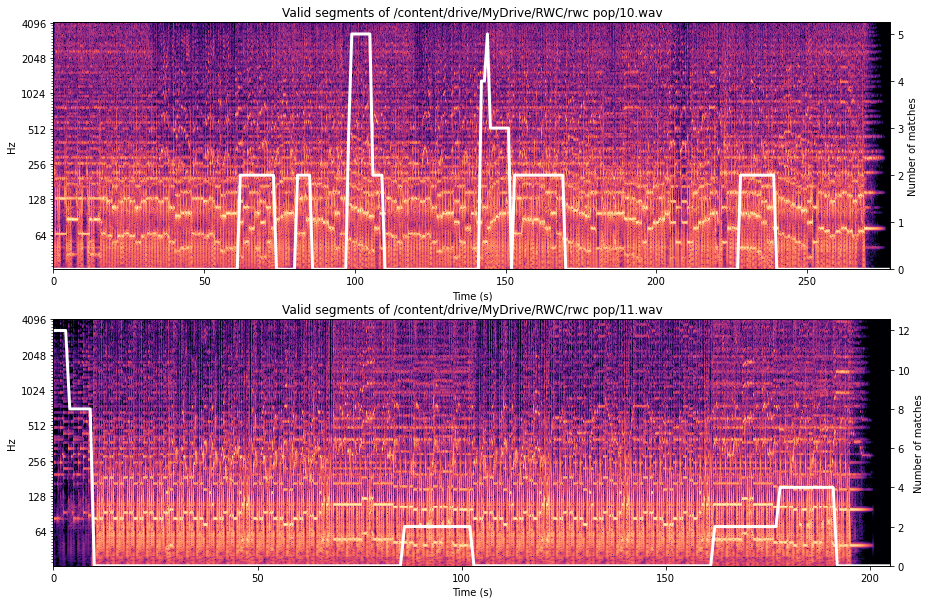

In [12]:
segment_matches1 = np.zeros(y1.shape[0])
segment_matches2 = np.zeros(y2.shape[0])

for pair in pairs:

    # get starting and ending frame indices
    start, end = (f_frames1[pair[0]][pair[1]][0], 
                  f_frames1[pair[0]][pair[1]][0] + f_frames1[pair[0]][pair[1]][1])
    # make a samples array with 1s during the segment
    seg1 = np.zeros(y1.shape[0])
    seg1[start:end] = 1
    # add segment to segment_matches
    segment_matches1 += seg1

    # get starting and ending frame indices
    start, end = (f_frames2[pair[2]][pair[3]][0], 
                  f_frames2[pair[2]][pair[3]][0] + f_frames2[pair[2]][pair[3]][1])
    # make a samples array with 1s during the segment
    seg2 = np.zeros(y2.shape[0])
    seg2[start:end] = 1
    # add segment to segment_matches
    segment_matches2 += seg2

# plot CQT and segment matches on top
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

librosa.display.specshow(C1, y_axis='cqt_hz', sr=22050,
                                bins_per_octave=BINS_PER_OCTAVE,
                                x_axis='s', ax=ax[0])
ax0 = ax[0].twinx()  # twin axis
segment_matches1 = segment_matches1[::22050]  # subsample to seconds indexing
ax0.plot(segment_matches1, color="white", linewidth=3)
ax0.set_ylabel("Number of matches")
ax0.set_ylim(ymin=0)
ax[0].set(title='Valid segments of ' + path1)


librosa.display.specshow(C2, y_axis='cqt_hz', sr=22050,
                                bins_per_octave=BINS_PER_OCTAVE,
                                x_axis='s', ax=ax[1])
ax1 = ax[1].twinx()  # twin axis
segment_matches2 = segment_matches2[::22050]  # subsample to seconds indexing
ax1.plot(segment_matches2, color="white", linewidth=3)
ax1.set_ylabel("Number of matches")
ax1.set_ylim(ymin=0)
ax[1].set(title='Valid segments of ' + path2)

#### >> Matches of 3 largest segments

In the paper I propose some further filtering we can do to the matches depending on the knowledge of our dataset. One of these is selecting only the 3 largest unique segments that have been paired. 

[Text(0.5, 1.0, 'Unique, largest 3 matched segments of /content/drive/MyDrive/RWC/rwc pop/11.wav')]

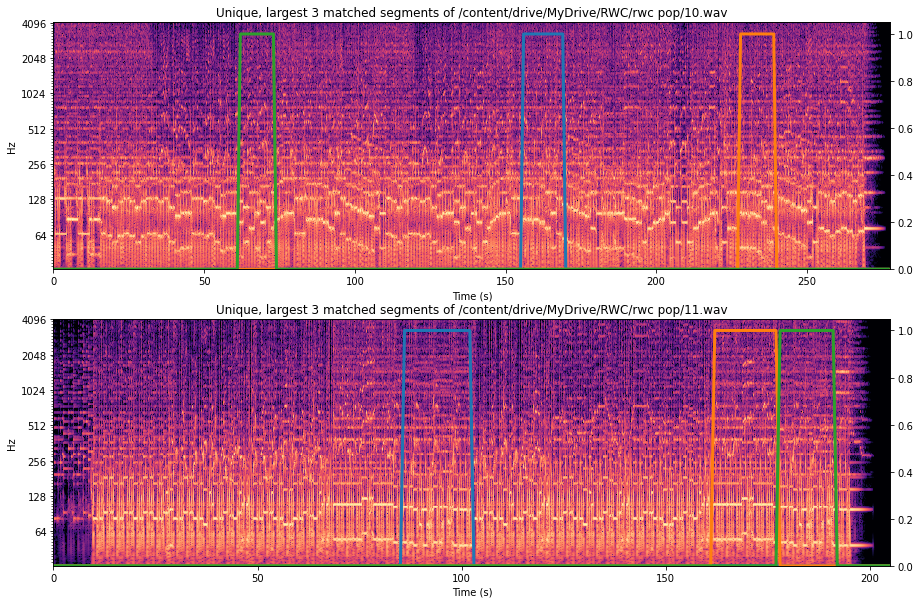

In [13]:
# get 3 pair with the largest segments
first = second = third = pairs[0]
for pair in pairs:
    # get segment size in frames from k and structure index
    # ensure they are unique segments across hierarchies
    if f_frames1[pair[0]][pair[1]][1] > f_frames1[first[0]][first[1]][1]:
        third = second
        second = first
        first = pair
    elif (f_frames1[pair[0]][pair[1]][1] > f_frames1[second[0]][second[1]][1]):
        if (f_frames1[pair[0]][pair[1]][1] != f_frames1[first[0]][first[1]][1]):
            third = second
            second = pair
    elif (f_frames1[pair[0]][pair[1]][1] > f_frames1[third[0]][third[1]][1]):
        if (f_frames1[pair[0]][pair[1]][1] != f_frames1[second[0]][second[1]][1]):
            if (f_frames1[pair[0]][pair[1]][1] != f_frames1[first[0]][first[1]][1]):
                third = pair
                
# arrays to store arrays of samples for 3 largest segments
segments1 = []
segments2 = []

for pair in [first, second, third]:

    # get starting and ending frame indices
    start, end = (f_frames1[pair[0]][pair[1]][0], 
                  f_frames1[pair[0]][pair[1]][0] + f_frames1[pair[0]][pair[1]][1])
    # make a samples array with 1s during the segment
    seg1 = np.zeros(y1.shape[0])
    seg1[start:end] = 1
    # append each segment sample array individually
    segments1.append(seg1)

    # get starting and ending frame indices
    start, end = (f_frames2[pair[2]][pair[3]][0], 
                  f_frames2[pair[2]][pair[3]][0] + f_frames2[pair[2]][pair[3]][1])
    # make a samples array with 1s during the segment
    seg2 = np.zeros(y2.shape[0])
    seg2[start:end] = 1
    # append each segment sample array individually
    segments2.append(seg2)

# plot CQT and 3 segments with different colors on top
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

librosa.display.specshow(C1, y_axis='cqt_hz', sr=22050,
                                bins_per_octave=BINS_PER_OCTAVE,
                                x_axis='s', ax=ax[0])
ax0 = ax[0].twinx()  # twin axis
for individual_segment in segments1:
    individual_segment_sec = individual_segment[::22050]  # subsample to seconds indexing
    ax0.plot(individual_segment_sec, linewidth=3)
ax0.set_ylim(ymin=0)
ax[0].set(title='Unique, largest 3 matched segments of ' + path1)

librosa.display.specshow(C2, y_axis='cqt_hz', sr=22050,
                                bins_per_octave=BINS_PER_OCTAVE,
                                x_axis='s', ax=ax[1])
ax1 = ax[1].twinx()  # twin axis
for individual_segment in segments2:
    individual_segment_sec = individual_segment[::22050]  # subsample to seconds indexing
    ax1.plot(individual_segment_sec, linewidth=3)
ax1.set_ylim(ymin=0)
ax[1].set(title='Unique, largest 3 matched segments of ' + path2)
